<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[ 0.33222112, -2.41226488, -0.57447493, -0.99451354, -0.10123159,
         0.45012195],
       [ 0.42689499, -0.32794556,  0.73587088, -1.5708678 ,  1.99517237,
        -0.76904623],
       [-0.12498098,  2.49593013,  0.49686875, -0.16242721,  0.80591298,
        -1.39901732],
       [-1.35061638, -0.23499214, -0.96432745, -0.32844102,  0.82847588,
         0.75328852],
       [ 1.11593235,  1.0507665 ,  1.07186391,  0.77360663,  0.49211641,
        -0.39072279],
       [ 1.67894442, -1.04645689,  1.00230941,  1.65653634,  0.06776736,
        -0.87730954],
       [-0.81385216, -0.43764402,  0.00251928,  0.7513723 ,  1.27300485,
        -1.01941702],
       [-0.2553769 , -2.19609962,  0.63434036, -0.10943881,  0.57726889,
        -0.05000825]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.126146,-0.388588,0.300621,0.001978,0.742311,-0.412764
std,0.985381,1.613205,0.744624,1.035790,0.667530,0.748312
min,-1.350616,-2.412265,-0.964327,-1.570868,-0.101232,-1.399017
25%,-0.394996,-1.333868,-0.141729,-0.494959,0.386029,-0.912836
50%,0.103620,-0.382795,0.565605,-0.135933,0.691591,-0.579885
75%,0.599154,0.086448,0.802481,0.756931,0.939608,0.075024
max,1.678944,2.495930,1.071864,1.656536,1.995172,0.753289


In [16]:
df

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,0.332221,0.426895,-0.124981,-1.350616,1.115932,1.678944,-0.813852,-0.255377
B,-2.412265,-0.327946,2.495930,-0.234992,1.050766,-1.046457,-0.437644,-2.196100
C,-0.574475,0.735871,0.496869,-0.964327,1.071864,1.002309,0.002519,0.634340
D,-0.994514,-1.570868,-0.162427,-0.328441,0.773607,1.656536,0.751372,-0.109439
E,-0.101232,1.995172,0.805913,0.828476,0.492116,0.067767,1.273005,0.577269
F,0.450122,-0.769046,-1.399017,0.753289,-0.390723,-0.877310,-1.019417,-0.050008


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,0.450122,-0.101232,-0.994514,-0.574475,-2.412265,0.332221
2023-01-02,-0.769046,1.995172,-1.570868,0.735871,-0.327946,0.426895
2023-01-03,-1.399017,0.805913,-0.162427,0.496869,2.495930,-0.124981
2023-01-04,0.753289,0.828476,-0.328441,-0.964327,-0.234992,-1.350616
2023-01-05,-0.390723,0.492116,0.773607,1.071864,1.050766,1.115932
2023-01-06,-0.877310,0.067767,1.656536,1.002309,-1.046457,1.678944
2023-01-07,-1.019417,1.273005,0.751372,0.002519,-0.437644,-0.813852
2023-01-08,-0.050008,0.577269,-0.109439,0.634340,-2.196100,-0.255377


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017


In [20]:
df

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    0.332221
2023-01-02    0.426895
2023-01-03   -0.124981
2023-01-04   -1.350616
2023-01-05    1.115932
2023-01-06    1.678944
2023-01-07   -0.813852
2023-01-08   -0.255377
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289


In [24]:
df

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008


##Selection by label

In [25]:
df.loc[dates[1]]

A    0.426895
B   -0.327946
C    0.735871
D   -1.570868
E    1.995172
F   -0.769046
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,0.332221,-0.994514
2023-01-02,0.426895,-1.570868
2023-01-03,-0.124981,-0.162427
2023-01-04,-1.350616,-0.328441
2023-01-05,1.115932,0.773607
2023-01-06,1.678944,1.656536
2023-01-07,-0.813852,0.751372
2023-01-08,-0.255377,-0.109439


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-1.350616,-0.328441
2023-01-05,1.115932,0.773607
2023-01-06,1.678944,1.656536


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -1.350616
D   -0.328441
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

-1.5708678010696688

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

-1.5708678010696688

##Selection by position

In [31]:
df.iloc[3]

A   -1.350616
B   -0.234992
C   -0.964327
D   -0.328441
E    0.828476
F    0.753289
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-1.350616,-0.234992
2023-01-05,1.115932,1.050766


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,0.426895,0.735871
2023-01-03,-0.124981,0.496869
2023-01-05,1.115932,1.071864


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,-2.412265,-0.574475
2023-01-02,-0.327946,0.735871
2023-01-03,2.495930,0.496869
2023-01-04,-0.234992,-0.964327
2023-01-05,1.050766,1.071864
2023-01-06,-1.046457,1.002309
2023-01-07,-0.437644,0.002519
2023-01-08,-2.196100,0.634340


In [36]:
# For getting values explicitly
df.iloc[1, 1]

-0.3279455645959905

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

-0.3279455645959905

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,0.332221,NaN,NaN,NaN,NaN,0.450122
2023-01-02,0.426895,NaN,0.735871,NaN,1.995172,NaN
2023-01-03,NaN,2.495930,0.496869,NaN,0.805913,NaN
2023-01-04,NaN,NaN,NaN,NaN,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,NaN
2023-01-06,1.678944,NaN,1.002309,1.656536,0.067767,NaN
2023-01-07,NaN,NaN,0.002519,0.751372,1.273005,NaN
2023-01-08,NaN,NaN,0.634340,NaN,0.577269,NaN


In [40]:
df

,A,B,C,D,E,F
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,0.332221,-2.412265,-0.574475,-0.994514,-0.101232,0.450122,one
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046,one
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017,two
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289,three
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723,four
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310,three
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417,five
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017,two
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723,four
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,-0.101232,0.450122,NaN
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,1.995172,-0.769046,1.0
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,0.805913,-1.399017,2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,0.828476,0.753289,3.0
2023-01-05,1.115932,1.050766,1.071864,0.773607,0.492116,-0.390723,4.0
2023-01-06,1.678944,-1.046457,1.002309,1.656536,0.067767,-0.877310,5.0
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,1.273005,-1.019417,6.0
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,0.577269,-0.050008,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,5,0.450122,NaN
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,5,-0.769046,1.0
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,5,-1.399017,2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,5,0.753289,3.0
2023-01-05,1.115932,1.050766,1.071864,0.773607,5,-0.390723,4.0
2023-01-06,1.678944,-1.046457,1.002309,1.656536,5,-0.877310,5.0
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,5,-1.019417,6.0
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,5,-0.050008,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,-5,-0.450122,NaN
2023-01-02,-0.426895,-0.327946,-0.735871,-1.570868,-5,-0.769046,-1.0
2023-01-03,-0.124981,-2.495930,-0.496869,-0.162427,-5,-1.399017,-2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,-5,-0.753289,-3.0
2023-01-05,-1.115932,-1.050766,-1.071864,-0.773607,-5,-0.390723,-4.0
2023-01-06,-1.678944,-1.046457,-1.002309,-1.656536,-5,-0.877310,-5.0
2023-01-07,-0.813852,-0.437644,-0.002519,-0.751372,-5,-1.019417,-6.0
2023-01-08,-0.255377,-2.196100,-0.634340,-0.109439,-5,-0.050008,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,5,0.450122,1.0,1.0
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,5,-0.769046,1.0,1.0
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,5,-1.399017,2.0,2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,5,0.753289,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,5,0.450122,1.0,1.0
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,5,-0.769046,1.0,1.0
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,5,-1.399017,2.0,2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,5,0.753289,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,5,0.450122,1.0,1.0
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,5,-0.769046,1.0,1.0
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,5,-1.399017,2.0,2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,5,0.753289,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,5,0.450122,NaN
2023-01-02,0.426895,-0.327946,0.735871,-1.570868,5,-0.769046,1.0
2023-01-03,-0.124981,2.495930,0.496869,-0.162427,5,-1.399017,2.0
2023-01-04,-1.350616,-0.234992,-0.964327,-0.328441,5,0.753289,3.0
2023-01-05,1.115932,1.050766,1.071864,0.773607,5,-0.390723,4.0
2023-01-06,1.678944,-1.046457,1.002309,1.656536,5,-0.877310,5.0
2023-01-07,-0.813852,-0.437644,0.002519,0.751372,5,-1.019417,6.0
2023-01-08,-0.255377,-2.196100,0.634340,-0.109439,5,-0.050008,NaN


In [56]:
df.mean()

A    0.084618
B   -0.087055
C    0.300621
D    0.001978
E    5.000000
F   -0.412764
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-1.124981,1.495930,-0.503131,-1.162427,4.0,-2.399017,1.0
2023-01-04,-4.350616,-3.234992,-3.964327,-3.328441,2.0,-2.246711,0.0
2023-01-05,-2.884068,-2.949234,-2.928136,-3.226393,1.0,-4.390723,0.0
2023-01-06,-3.321056,-6.046457,-3.997691,-3.343464,0.0,-5.877310,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-6.255377,-8.196100,-5.365660,-6.109439,-1.0,-6.050008,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.574475,-0.994514,5,0.450122,NaN
2023-01-02,0.426895,-0.327946,0.161396,-2.565381,10,-0.318924,1.0
2023-01-03,0.301914,2.167985,0.658265,-2.727809,15,-1.717942,3.0
2023-01-04,-1.048702,1.932992,-0.306063,-3.056250,20,-0.964653,6.0
2023-01-05,0.067230,2.983759,0.765801,-2.282643,25,-1.355376,10.0
2023-01-06,1.746174,1.937302,1.768111,-0.626107,30,-2.232685,15.0
2023-01-07,0.932322,1.499658,1.770630,0.125266,35,-3.252102,21.0
2023-01-08,0.676945,-0.696442,2.404970,0.015827,40,-3.302111,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    3.029561
B    4.692030
C    2.036191
D    3.227404
E    0.000000
F    2.152306
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    0
1    3
2    6
3    0
4    1
5    0
6    0
7    6
8    4
9    3
dtype: int64

In [62]:
s.value_counts()

0    4
3    2
6    2
1    1
4    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-0.394062,1.802179,-0.241629,0.241897
1,-0.601161,-1.117687,0.352069,-0.492316
2,0.509712,0.599026,-0.978800,1.057723
3,-0.797788,-1.154359,1.084112,-0.032524
4,-0.309025,0.157294,-0.006180,-1.125721
5,-0.210321,-1.087440,-0.635774,1.022628
6,-0.135850,0.015585,1.121558,0.518616
7,-0.549979,-0.688744,1.239209,-1.429950
8,1.285142,0.037795,-1.155304,0.136422
9,-0.920323,1.663918,0.082167,-1.927959


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-0.394062,1.802179,-0.241629,0.241897
1,-0.601161,-1.117687,0.352069,-0.492316
2,0.509712,0.599026,-0.978800,1.057723
3,-0.797788,-1.154359,1.084112,-0.032524
4,-0.309025,0.157294,-0.006180,-1.125721
5,-0.210321,-1.087440,-0.635774,1.022628
6,-0.135850,0.015585,1.121558,0.518616
7,-0.549979,-0.688744,1.239209,-1.429950
8,1.285142,0.037795,-1.155304,0.136422
9,-0.920323,1.663918,0.082167,-1.927959


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,0.305856,0.374899
1,bar,one,-0.434630,0.804325
2,foo,two,-0.784657,-1.543034
3,bar,three,-0.379960,-0.694535
4,foo,two,0.305484,-2.421756
5,bar,two,1.302433,0.706275
6,foo,one,-0.045923,-0.975114
7,foo,three,1.161627,0.120140


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,0.487843,0.816065
foo,0.942387,-4.444865


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -0.434630  0.804325
    three -0.379960 -0.694535
    two    1.302433  0.706275
foo one    0.259933 -0.600215
    three  1.161627  0.120140
    two   -0.479174 -3.964790

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.974265  0.707562
      two     0.930073 -0.475661
baz   one     0.815447  2.444920
      two    -0.537378  0.091147

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.974265
               B    0.707562
       two     A    0.930073
               B   -0.475661
baz    one     A    0.815447
               B    2.444920
       two     A   -0.537378
               B    0.091147
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one    -0.974265  0.707562
      two     0.930073 -0.475661
baz   one     0.815447  2.444920
      two    -0.537378  0.091147

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.974265  0.930073
      B  0.707562 -0.475661
baz   A  0.815447 -0.537378
      B  2.444920  0.091147

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.974265  0.815447
       B  0.707562  2.444920
two    A  0.930073 -0.537378
       B -0.475661  0.091147

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,0.294258,0.104458
1,one,B,foo,-0.257603,-1.435485
2,two,C,foo,-0.124942,0.789210
3,three,A,bar,-1.510871,-0.494198
4,one,B,bar,0.207266,-0.793582
5,one,C,bar,1.108558,-1.471330
6,two,A,foo,-1.303318,1.546064
7,three,B,foo,-1.635655,-2.453555
8,one,C,foo,-0.165074,0.137630
9,one,A,bar,-1.174327,-0.685659


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -1.174327  0.294258
      B  0.207266 -0.257603
      C  1.108558 -0.165074
three A -1.510871       NaN
      B       NaN -1.635655
      C  0.657058       NaN
two   A       NaN -1.303318
      B  0.548875       NaN
      C       NaN -0.124942

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24367
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06    0.021799
2012-03-07   -1.543425
2012-03-08   -0.883869
2012-03-09   -1.485580
2012-03-10    0.740860
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00    0.021799
2012-03-07 00:00:00+00:00   -1.543425
2012-03-08 00:00:00+00:00   -0.883869
2012-03-09 00:00:00+00:00   -1.485580
2012-03-10 00:00:00+00:00    0.740860
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00    0.021799
2012-03-06 19:00:00-05:00   -1.543425
2012-03-07 19:00:00-05:00   -0.883869
2012-03-08 19:00:00-05:00   -1.485580
2012-03-09 19:00:00-05:00    0.740860
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    2.453598
2012-02-29    1.361219
2012-03-31    0.399957
2012-04-30   -0.049800
2012-05-31    0.344481
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01    2.453598
2012-02    1.361219
2012-03    0.399957
2012-04   -0.049800
2012-05    0.344481
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    2.453598
2012-02-01    1.361219
2012-03-01    0.399957
2012-04-01   -0.049800
2012-05-01    0.344481
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00    2.359423
1990-06-01 09:00    0.941939
1990-09-01 09:00    0.044370
1990-12-01 09:00   -1.032994
1991-03-01 09:00    1.021164
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

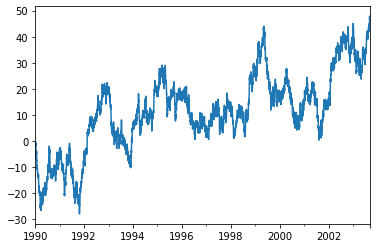

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 432x288 with 0 Axes>

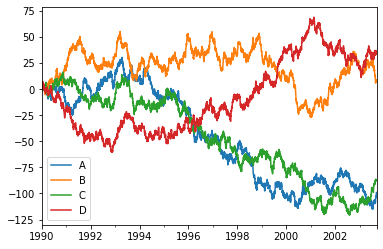

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,1.992162,1.541625,0.758503,0.680948
1,1990-01-02,2.510063,1.742685,0.512124,0.185782
2,1990-01-03,2.790303,1.595786,1.808289,-0.144876
3,1990-01-04,2.295217,1.358262,1.730917,-0.190408
4,1990-01-05,2.176711,0.731517,0.533824,0.856220
...,...,...,...,...,...
4995,2003-09-05,-102.375677,7.681711,-87.438338,35.672882
4996,2003-09-06,-100.784201,7.167640,-86.873175,34.041283
4997,2003-09-07,-101.017256,8.043061,-87.197313,34.448147
4998,2003-09-08,-99.016099,7.805726,-87.726259,34.219198


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,1.992162,1.541625,0.758503,0.680948
1990-01-02,2.510063,1.742685,0.512124,0.185782
1990-01-03,2.790303,1.595786,1.808289,-0.144876
1990-01-04,2.295217,1.358262,1.730917,-0.190408
1990-01-05,2.176711,0.731517,0.533824,0.856220
...,...,...,...,...
2003-09-05,-102.375677,7.681711,-87.438338,35.672882
2003-09-06,-100.784201,7.167640,-86.873175,34.041283
2003-09-07,-101.017256,8.043061,-87.197313,34.448147
2003-09-08,-99.016099,7.805726,-87.726259,34.219198


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,1.992162,1.541625,0.758503,0.680948
1,1990-01-02,2.510063,1.742685,0.512124,0.185782
2,1990-01-03,2.790303,1.595786,1.808289,-0.144876
3,1990-01-04,2.295217,1.358262,1.730917,-0.190408
4,1990-01-05,2.176711,0.731517,0.533824,0.856220
...,...,...,...,...,...
4995,2003-09-05,-102.375677,7.681711,-87.438338,35.672882
4996,2003-09-06,-100.784201,7.167640,-86.873175,34.041283
4997,2003-09-07,-101.017256,8.043061,-87.197313,34.448147
4998,2003-09-08,-99.016099,7.805726,-87.726259,34.219198


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -0.637906
b   -0.397409
c   -0.765078
d    1.244549
e   -0.425935
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0    1.446547
1    0.929786
2    0.391758
3    0.077700
4    1.657251
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

b   -0.397409
d    1.244549
dtype: float64

In [133]:
import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN
